In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import zipfile
import os
zip_file_path='/content/drive/MyDrive/archive (2).zip'
destination_folder='/content/brain_tumor'

if not os.path.exists(destination_folder):
  os.makedirs(destination_folder)

with zipfile.ZipFile(zip_file_path,'r') as zip_ref:
  zip_ref.extractall(destination_folder)

print(f'Extracted files:{destination_folder}')

Extracted files:/content/brain_tumor


In [35]:
pip install pydicom

In [36]:
import os
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import pydicom
import numpy as np

In [37]:
class SegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.images = []
        self.masks = []

        for folder in ['aneurysm', 'cancer', 'tumor']:
            folder_path = os.path.join(root_dir, folder)
            for file in os.listdir(folder_path):
                if file.endswith('.jpg'):
                    image_path = os.path.join(folder_path, file)
                    mask_path = os.path.join(folder_path, file.replace('.jpg', '.dcm'))
                    self.images.append(image_path)
                    self.masks.append(mask_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        mask_dcm = pydicom.dcmread(mask_path)
        mask = mask_dcm.pixel_array.astype(np.uint8)
        mask = Image.fromarray(mask)

        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = SegmentationDataset(root_dir="/content/brain_tumor/files", transform=transform, target_transform=mask_transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [38]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            self.conv_block(3, 64),
            self.conv_block(64, 128),
            self.conv_block(128, 256),
            self.conv_block(256, 512)
        )
        self.decoder = nn.Sequential(
            self.upconv_block(512, 256),
            self.upconv_block(256, 128),
            self.upconv_block(128, 64),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)

        output = F.interpolate(dec, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)


In [39]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            outputs = model(images)

            masks_resized = F.interpolate(masks, size=outputs.shape[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, masks_resized)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")

train_model(model, dataloader, criterion, optimizer, num_epochs=20)

Epoch [1/20], Loss: 0.6128622554815732
Epoch [2/20], Loss: 0.5645838315670307
Epoch [3/20], Loss: 0.5331322298600123
Epoch [4/20], Loss: 0.5130659479361314
Epoch [5/20], Loss: 0.5025156534635103
Epoch [6/20], Loss: 0.4907244989505181
Epoch [7/20], Loss: 0.4847695025113913
Epoch [8/20], Loss: 0.48036270233301015
Epoch [9/20], Loss: 0.4707374224295983
Epoch [10/20], Loss: 0.46641821356920093
Epoch [11/20], Loss: 0.46377359353579006
Epoch [12/20], Loss: 0.46276053832127495
Epoch [13/20], Loss: 0.4566292377618643
Epoch [14/20], Loss: 0.46325943974348216
Epoch [15/20], Loss: 0.45825167573415315
Epoch [16/20], Loss: 0.4505566427340874
Epoch [17/20], Loss: 0.4485340792399186
Epoch [18/20], Loss: 0.4465983331203461
Epoch [19/20], Loss: 0.4447809480703794
Epoch [20/20], Loss: 0.4428989433325254


In [46]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

def test_single_image(model, image_path, transform, device):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)

        probs = torch.sigmoid(output)
        pred_mask = (probs > 0.5).float()

    pred_mask = pred_mask.squeeze(0).cpu().numpy()

    return pred_mask


image_path = "/content/brain_tumor/files/cancer/10.jpg"
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)


pred_mask = test_single_image(model, image_path, test_transform, device)




In [47]:
def test_single_image(model, image_path, transform, device):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)

        probs = torch.sigmoid(output)
        pred_mask = (probs > 0.5).float()

    pred_mask = pred_mask.squeeze(0).cpu().numpy()

    print(f"Predicted mask range: {pred_mask.min()} to {pred_mask.max()}")

    return pred_mask


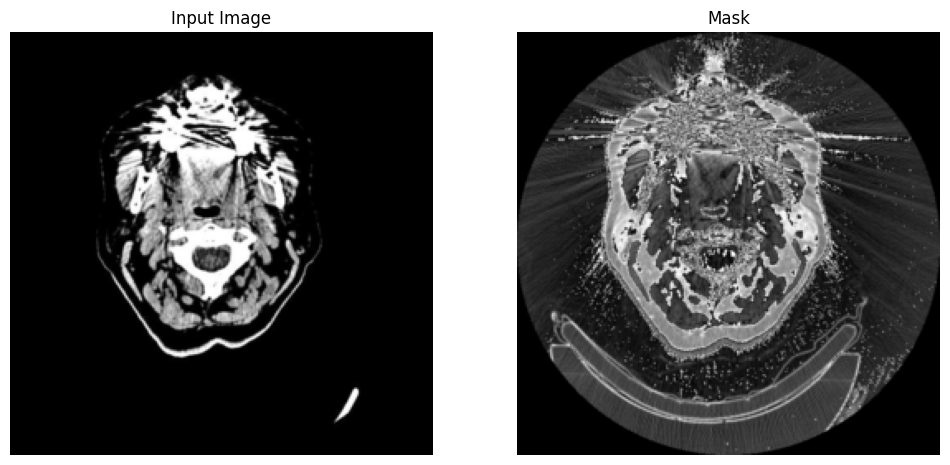

In [48]:
def visualize_training_data(dataset, idx=0):
    image, mask = dataset[idx]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(0), cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.show()

visualize_training_data(dataset, idx=0)
